# Movie Recommender Capstone Project

This project seeks to take a couple of different approaches to recommendation systems. Data comes from movielens.org and tmdb.org. 

In [2]:
import pandas as pd
import numpy as np
import json

In [3]:
ratings_df = pd.read_csv('data/ratings.csv')
ratings_df = ratings_df.drop(columns = 'timestamp')
ratings_df.dropna(inplace=True)

In [4]:
ratings_df.count()

userId     25000095
movieId    25000095
rating     25000095
dtype: int64

In [5]:
ratings_df.tail()

,userId,movieId,rating
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0
25000094,162541,63876,5.0


In [6]:
ratings_df.groupby('userId').agg(count=('rating', 'count')).count()

count    162541
dtype: int64

# Apply ratings table filters.
- Original dataset consists of 25M unique movie ratings from 162,541 users and 59,047 movies. 
- Sparseness 0.0026
- Filtering will help to reduce the sparseness and may allow us to get better predictions from the models.


## *Thumbs up* filter
- Delete movies that almost no one has rated highly.
- 59047 movies in original dataset. 
- Drop 26,448 movies that received no 4.5 or 5 star reviews. Yields 32,599 movies.
- Drop 5,685 movies that had a stat score (mean + 1.5 std) less than 4.4. Very low likelihood of recommendation.
- Drop 14,320 movies with less than 30 reviews.
- Yields 12,594 movies.
- Seems low, but that still is a lot of movies. And definitely enough for this test.
> - What did the filtering do to the total number of ratings?
> - 25M ratings in prefiltered dataset. 22M in the filtered dataset.

### Filter out movies with no 4.5 or 5 star ratings

In [7]:

has_high_ratings = ratings_df[ratings_df['rating']>=4.5]
plus_45_by_movie = has_high_ratings.groupby('movieId').count()
plus_45_by_movie.rename(columns={'rating':'4.5+ star'}, inplace=True)
plus_45_by_movie.head(3)

,userId,4.5+ star
movieId,,
1,18835,18835
2,2667,2667
3,1163,1163


In [8]:
plus_45_by_movie.shape

(32599, 2)

In [9]:
# Group movies by rating and get their mean and std ratings. Alternatively, we could count the number of 5's. Drop if less than 5%.
movie = ratings_df.groupby('movieId').agg(count = ('rating', 'count'), mean = ('rating', 'mean'), std= ('rating','std'))
movie.head(1)

,count,mean,std
movieId,,,
1,57309,3.893708,0.921552


In [10]:
movie.shape

(59047, 3)

In [11]:
movie = movie.merge(plus_45_by_movie, how='inner', left_on='movieId', right_on='movieId')
movie['4.5+ star'].shape # count of movies with 4.5 and 5 star reviews

(32599,)

### Filter our movies with low ratings stat score (mean+1.5*std < 4.4)

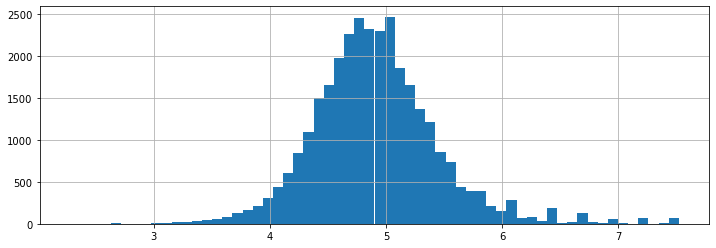

In [12]:
# Of the remaining movies, filter out those that have a mean + 1.5x std of rating below 4.4.
movie['stat_score'] = movie['mean'] + 1.5 * movie['std']
movie['stat_score'].hist(bins=60, figsize=(12,4))

In [13]:
thumbs_up = movie[movie['stat_score'] >= 4.4]

In [14]:
thumbs_up = thumbs_up.drop(columns=['userId','4.5+ star'])
thumbs_up.shape

(26914, 4)

In [15]:
thumbs_up.head(2)

,count,mean,std,stat_score
movieId,,,,
1,57309,3.893708,0.921552,5.276036
2,24228,3.251527,0.959851,4.691304


### *Movies with too few ratings* filter

In [16]:
thumbs_up = thumbs_up[thumbs_up['count']>30]

In [17]:
thumbs_up.count()

count         12594
mean          12594
std           12594
stat_score    12594
dtype: int64

In [18]:
thumbs_up.head(3)

,count,mean,std,stat_score
movieId,,,,
1,57309,3.893708,0.921552,5.276036
2,24228,3.251527,0.959851,4.691304
3,11804,3.142028,1.008443,4.654692


### Apply filter to links file to get a good list for web scraping of movies.

In [19]:
# movie_list = pd.read_csv('data/links.csv')

In [20]:
# filtered_movies = movie_list.merge(thumbs_up, how='inner', left_on='movieId', right_on='movieId')

In [21]:
# filtered_movies.head(1)

In [22]:
# filtered_movies.to_csv('data/filtered_links.csv', index=False)

### Apply 'thumbs up' filter to ratings data table

In [23]:
thumbs_up_ratings = ratings_df.merge(thumbs_up, how='inner', left_on='movieId', right_on='movieId')

In [24]:
thumbs_up_ratings.shape

(22732866, 7)

In [25]:
thumbs_up_ratings.tail(2) # Filtered ratings db

,userId,movieId,rating,count,mean,std,stat_score
22732864,156183,177233,3.5,32,3.4375,1.119836,5.117254
22732865,159417,177233,3.0,32,3.4375,1.119836,5.117254


In [26]:
# thumbs_up_ratings.to_csv('data/filtered_ratings.csv', index=False)

### Remove data to make training more manageable
- More data is better, but I am limited to what I can do without signing up for a much bigger aws EC2 instance or Spark clusters
- Therefore, randomly select 33% of data
- Remove any users who now have fewer than 15 reviews in sampled dataset to make user/item matrix less sparse
- 104,964 users, 12,594 movies, 7.2M ratings, and 0.0056 sparsity

In [27]:
# Ratings dataset
thumbs_up_sample = thumbs_up_ratings.sample(frac=0.35, random_state=51)

In [28]:
# Grouped by users to remove users with not enough reviews
user_counts = thumbs_up_sample.groupby('userId').count()

In [29]:
user_counts.shape

(162533, 6)

In [30]:
sufficient_counts = user_counts[user_counts['count']>15]
sufficient_counts = sufficient_counts.drop(['movieId', 'rating', 'mean', 'std', 'stat_score'], axis =1)

In [31]:
sufficient_counts.shape

(104964, 1)

In [32]:
# New ratings dataset to see how the close-to-final is shaping up. Filtered out ratings from users who with not enough reviews
new_thumbs_up = thumbs_up_sample.merge(sufficient_counts, how='inner', left_on='userId', right_on='userId')
new_thumbs_up.head(1)

,userId,movieId,rating,count_x,mean,std,stat_score,count_y
0,40630,933,4.0,4827,3.994821,0.767646,5.14629,43


In [33]:
# 5.7M ratings, 91,783 users, 12,594 movies
sparsity = new_thumbs_up.shape[0] / (new_thumbs_up.groupby('userId').agg(count = ('rating', 'count')).count() * new_thumbs_up.groupby('movieId').agg(count = ('rating', 'count')).count())
sparsity

count    0.005597
dtype: float64

### Develop test dataset and remove test data from training dataset
- Test data includes 30 randomly selected movies from each user with more than 200 reviews (6394 users with 200+ reviews)
- Final test will be a pairwise comparison of the sum of the ratings for the top 5 predictions for each recommender

In [34]:
big_counts = sufficient_counts[sufficient_counts['count']>200]
less_big_counts = sufficient_counts[sufficient_counts['count']<=200]

In [35]:
big_counts.shape

(6394, 1)

In [36]:
big_users_ratings_df = thumbs_up_sample.merge(big_counts, how='inner', left_on='userId', right_on='userId')
test_ratings_df = big_users_ratings_df.groupby('userId').apply(lambda x: x.sample(n=30)).reset_index(drop = True)

In [37]:
test_ratings_df.head()

,userId,movieId,rating,count_x,mean,std,stat_score,count_y
0,3,54001,4.0,14346,3.768890,1.006514,5.278662,223
1,3,68157,4.0,23077,4.011397,0.894771,5.353553,223
2,3,5400,4.0,4028,3.195382,0.888666,4.528382,223
3,3,1584,4.0,21638,3.684536,0.955911,5.118403,223
4,3,7149,4.0,3677,3.472124,0.914740,4.844235,223


In [38]:
train_ratings_df = new_thumbs_up.merge(test_ratings_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
train_ratings_df.shape


(7206304, 9)

In [53]:
train_ratings_df.to_csv('data/train_ratings_df.csv', index=False)
test_ratings_df.to_csv('data/test_ratings_df.csv', index=False)


In [60]:
train_ratings_df.groupby('userId').agg(count = ('rating', 'count')).count()

count    104964
dtype: int64

### Develop production dataset and push to s3
- 

In [39]:
prod_data = train_ratings_df[['userId','movieId', 'rating']]
prod_data = prod_data.sample(frac = 0.264) # Same size dataset as that which models were trained on. 55 sec until prediction
prod_data = prod_data.sample(frac = 0.2) # 18 seconds until prediction

In [40]:
prod_data

,userId,movieId,rating
3869656,106234,1356,4.0
2581376,161277,920,5.0
5338467,65887,1370,2.0
2694099,75235,49530,4.0
2169057,127206,102445,3.0
...,...,...,...
2155271,157621,1608,5.0
655628,128243,3448,4.0
6694626,86927,1197,5.0
4061556,86587,590,3.0


In [42]:
from io import StringIO # python3; python2: BytesIO 
import boto3

bucket = 'galvrjsbucket' # already created on S3
csv_buffer = StringIO()
prod_data.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'prod_data.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'C2ADF40EF57C98E0',
  'HostId': 'epe7j7E2MEH1vKU8udCgqYa476zBllDsFJa1JMbsD82jUXiEpjgf8XPlYCqptwqnmrGhQlLtwlU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'epe7j7E2MEH1vKU8udCgqYa476zBllDsFJa1JMbsD82jUXiEpjgf8XPlYCqptwqnmrGhQlLtwlU=',
   'x-amz-request-id': 'C2ADF40EF57C98E0',
   'date': 'Tue, 22 Sep 2020 21:53:57 GMT',
   'etag': '"8e2dfc27caf3b169871cc855fc829a53"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8e2dfc27caf3b169871cc855fc829a53"'}